In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

### Filter out corrupted images
When working with lots of real-world image data, corrupted images are a common occurence. Let's filter out badly-encoded images that do not feature the string "JFIF" in their header.

In [2]:
import os

num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()
        
        if not is_jfif:
            num_skipped += 1
            os.remove(fpath)
print("Deleted %d images" % num_skipped)

Deleted 0 images


In [3]:
image_size = (180, 180)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 23379 files belonging to 2 classes.
Using 18704 files for training.


2022-06-25 11:18:39.745558: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-25 11:18:39.767643: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-25 11:18:39.767756: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-25 11:18:39.768437: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Found 23379 files belonging to 2 classes.
Using 4675 files for validation.


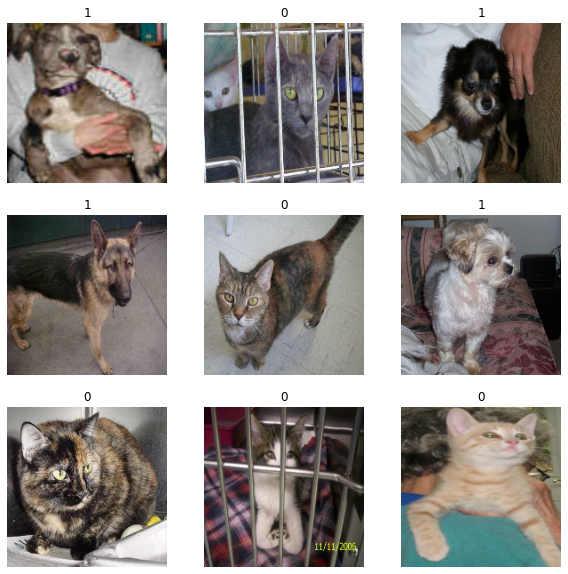

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [5]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

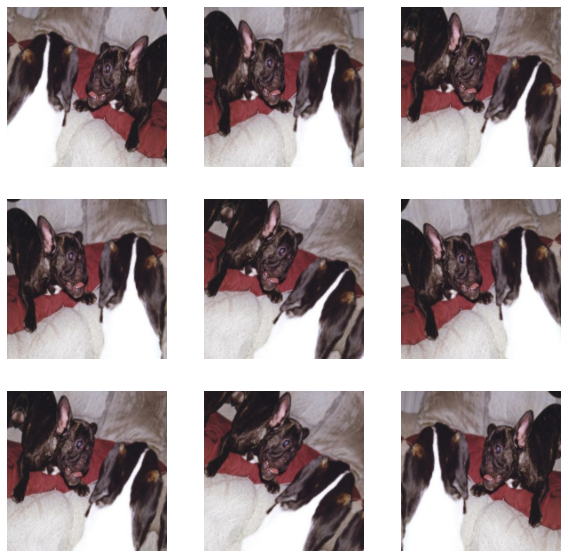

In [6]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [7]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

In [8]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    x = data_augmentation(inputs)
    
    x = layers.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    
    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    
    previous_block_activation = x  # Set aside residual
    
    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        
        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)
        
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual
        
    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    
    x = layers.GlobalAveragePooling2D()(x)
    
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes
        
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    
    return keras.Model(inputs, outputs)

In [9]:
model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [11]:
epochs = 50

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/50


Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
2022-06-25 11:20:54.222546: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2022-06-25 11:20:56.284954: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


 21/585 [>.............................] - ETA: 1:57 - loss: 0.7744 - accuracy: 0.5699

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


106/585 [====>.........................] - ETA: 1:37 - loss: 0.7380 - accuracy: 0.5767

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


109/585 [====>.........................] - ETA: 1:36 - loss: 0.7368 - accuracy: 0.5771

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


122/585 [=====>........................] - ETA: 1:34 - loss: 0.7337 - accuracy: 0.5763

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


212/585 [=========>....................] - ETA: 1:15 - loss: 0.7154 - accuracy: 0.5912

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


236/585 [===========>..................] - ETA: 1:11 - loss: 0.7130 - accuracy: 0.5936

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


313/585 [===============>..............] - ETA: 55s - loss: 0.6961 - accuracy: 0.6111

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


430/585 [=====================>........] - ETA: 31s - loss: 0.6779 - accuracy: 0.6275

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


585/585 [==============================] - ETA: 0s - loss: 0.6531 - accuracy: 0.6468

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


585/585 [==============================] - 132s 218ms/step - loss: 0.6531 - accuracy: 0.6468 - val_loss: 0.5790 - val_accuracy: 0.7082
Epoch 2/50
  1/585 [..............................] - ETA: 2:53 - loss: 0.6634 - accuracy: 0.6875

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 21/585 [>.............................] - ETA: 2:01 - loss: 0.5830 - accuracy: 0.6920

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


105/585 [====>.........................] - ETA: 1:40 - loss: 0.5549 - accuracy: 0.7247

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


108/585 [====>.........................] - ETA: 1:39 - loss: 0.5524 - accuracy: 0.7263

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


123/585 [=====>........................] - ETA: 1:35 - loss: 0.5515 - accuracy: 0.7254

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


211/585 [=========>....................] - ETA: 1:18 - loss: 0.5458 - accuracy: 0.7309

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


237/585 [===========>..................] - ETA: 1:12 - loss: 0.5422 - accuracy: 0.7336

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


312/585 [===============>..............] - ETA: 56s - loss: 0.5322 - accuracy: 0.7386

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


431/585 [=====================>........] - ETA: 32s - loss: 0.5220 - accuracy: 0.7459

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


585/585 [==============================] - ETA: 0s - loss: 0.5084 - accuracy: 0.7540

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


585/585 [==============================] - 126s 215ms/step - loss: 0.5084 - accuracy: 0.7540 - val_loss: 0.6168 - val_accuracy: 0.7048
Epoch 3/50
  1/585 [..............................] - ETA: 2:27 - loss: 0.4488 - accuracy: 0.7812

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 22/585 [>.............................] - ETA: 1:55 - loss: 0.4635 - accuracy: 0.7912

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


105/585 [====>.........................] - ETA: 1:37 - loss: 0.4600 - accuracy: 0.7860

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


108/585 [====>.........................] - ETA: 1:36 - loss: 0.4605 - accuracy: 0.7859

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


122/585 [=====>........................] - ETA: 1:34 - loss: 0.4554 - accuracy: 0.7894

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


212/585 [=========>....................] - ETA: 1:16 - loss: 0.4491 - accuracy: 0.7920

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


236/585 [===========>..................] - ETA: 1:11 - loss: 0.4454 - accuracy: 0.7937

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


312/585 [===============>..............] - ETA: 56s - loss: 0.4373 - accuracy: 0.7980

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


431/585 [=====================>........] - ETA: 31s - loss: 0.4298 - accuracy: 0.8032

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


585/585 [==============================] - ETA: 0s - loss: 0.4180 - accuracy: 0.8091

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


585/585 [==============================] - 125s 214ms/step - loss: 0.4180 - accuracy: 0.8091 - val_loss: 0.4095 - val_accuracy: 0.8130
Epoch 4/50
  1/585 [..............................] - ETA: 2:41 - loss: 0.5662 - accuracy: 0.8125

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 22/585 [>.............................] - ETA: 1:56 - loss: 0.4189 - accuracy: 0.8082

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


105/585 [====>.........................] - ETA: 1:40 - loss: 0.3728 - accuracy: 0.8298

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


108/585 [====>.........................] - ETA: 1:39 - loss: 0.3750 - accuracy: 0.8284

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


123/585 [=====>........................] - ETA: 1:36 - loss: 0.3752 - accuracy: 0.8283

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


212/585 [=========>....................] - ETA: 1:17 - loss: 0.3690 - accuracy: 0.8346

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


237/585 [===========>..................] - ETA: 1:12 - loss: 0.3683 - accuracy: 0.8354

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


313/585 [===============>..............] - ETA: 56s - loss: 0.3599 - accuracy: 0.8408

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


430/585 [=====================>........] - ETA: 32s - loss: 0.3538 - accuracy: 0.8448

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


585/585 [==============================] - ETA: 0s - loss: 0.3418 - accuracy: 0.8504

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


585/585 [==============================] - 126s 216ms/step - loss: 0.3418 - accuracy: 0.8504 - val_loss: 0.3288 - val_accuracy: 0.8618
Epoch 5/50
  1/585 [..............................] - ETA: 2:24 - loss: 0.3271 - accuracy: 0.8438

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 22/585 [>.............................] - ETA: 1:58 - loss: 0.3324 - accuracy: 0.8523

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


105/585 [====>.........................] - ETA: 1:39 - loss: 0.3201 - accuracy: 0.8661

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


108/585 [====>.........................] - ETA: 1:39 - loss: 0.3190 - accuracy: 0.8669

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


123/585 [=====>........................] - ETA: 1:36 - loss: 0.3151 - accuracy: 0.8686

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


212/585 [=========>....................] - ETA: 1:17 - loss: 0.3102 - accuracy: 0.8713

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


236/585 [===========>..................] - ETA: 1:12 - loss: 0.3096 - accuracy: 0.8706

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


312/585 [===============>..............] - ETA: 56s - loss: 0.3042 - accuracy: 0.8721

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


430/585 [=====================>........] - ETA: 32s - loss: 0.2967 - accuracy: 0.8742

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


585/585 [==============================] - ETA: 0s - loss: 0.2854 - accuracy: 0.8798

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


585/585 [==============================] - 126s 216ms/step - loss: 0.2854 - accuracy: 0.8798 - val_loss: 0.3067 - val_accuracy: 0.8635
Epoch 6/50
  1/585 [..............................] - ETA: 2:30 - loss: 0.2405 - accuracy: 0.9375

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 22/585 [>.............................] - ETA: 1:58 - loss: 0.2792 - accuracy: 0.8807

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


105/585 [====>.........................] - ETA: 1:39 - loss: 0.2716 - accuracy: 0.8818

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


108/585 [====>.........................] - ETA: 1:38 - loss: 0.2742 - accuracy: 0.8814

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


123/585 [=====>........................] - ETA: 1:35 - loss: 0.2667 - accuracy: 0.8859

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


212/585 [=========>....................] - ETA: 1:17 - loss: 0.2582 - accuracy: 0.8889

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


236/585 [===========>..................] - ETA: 1:12 - loss: 0.2600 - accuracy: 0.8884

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


313/585 [===============>..............] - ETA: 56s - loss: 0.2529 - accuracy: 0.8916

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


431/585 [=====================>........] - ETA: 31s - loss: 0.2510 - accuracy: 0.8925

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


585/585 [==============================] - ETA: 0s - loss: 0.2455 - accuracy: 0.8956

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


585/585 [==============================] - 127s 216ms/step - loss: 0.2455 - accuracy: 0.8956 - val_loss: 0.2002 - val_accuracy: 0.9200
Epoch 7/50
  1/585 [..............................] - ETA: 3:07 - loss: 0.1999 - accuracy: 0.9375

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 22/585 [>.............................] - ETA: 1:50 - loss: 0.2393 - accuracy: 0.8949

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


 30/585 [>.............................] - ETA: 1:50 - loss: 0.2324 - accuracy: 0.9021

KeyboardInterrupt: 

In [12]:
img = keras.preprocessing.image.load_img(
    "PetImages/Cat/6779.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent cat and %.2f percent dog."
    % (100 * (1 - score), 100 * score)
)

1/1 [==============================] - 0s 437ms/step
This image is 42.52 percent cat and 57.48 percent dog.


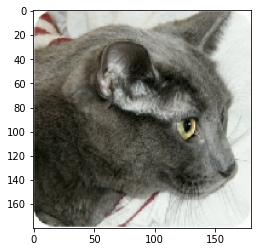

In [13]:
plt.imshow(img)